Using device: cuda
Test Classes: ['Tomato__Bacterial_spot', 'Tomato__Early_blight', 'Tomato__Late_blight', 'Tomato__Leaf_Mold', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites Two-spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato__healthy']


/home/guest/anvitha_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/guest/anvitha_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Classification Report:
                                              precision    recall  f1-score   support

                      Tomato__Bacterial_spot       0.93      0.88      0.90        16
                        Tomato__Early_blight       0.69      0.69      0.69        16
                         Tomato__Late_blight       1.00      0.75      0.86        16
                           Tomato__Leaf_Mold       0.88      0.94      0.91        16
                  Tomato__Septoria_leaf_spot       0.74      0.88      0.80        16
Tomato__Spider_mites Two-spotted_spider_mite       0.91      0.62      0.74        16
                         Tomato__Target_Spot       0.75      0.94      0.83        16
       Tomato__Tomato_Yellow_Leaf_Curl_Virus       0.94      1.00      0.97        16
                 Tomato__Tomato_mosaic_virus       0.94      0.94      0.94        16
                             Tomato__healthy       0.88      0.94      0.91        16

                            

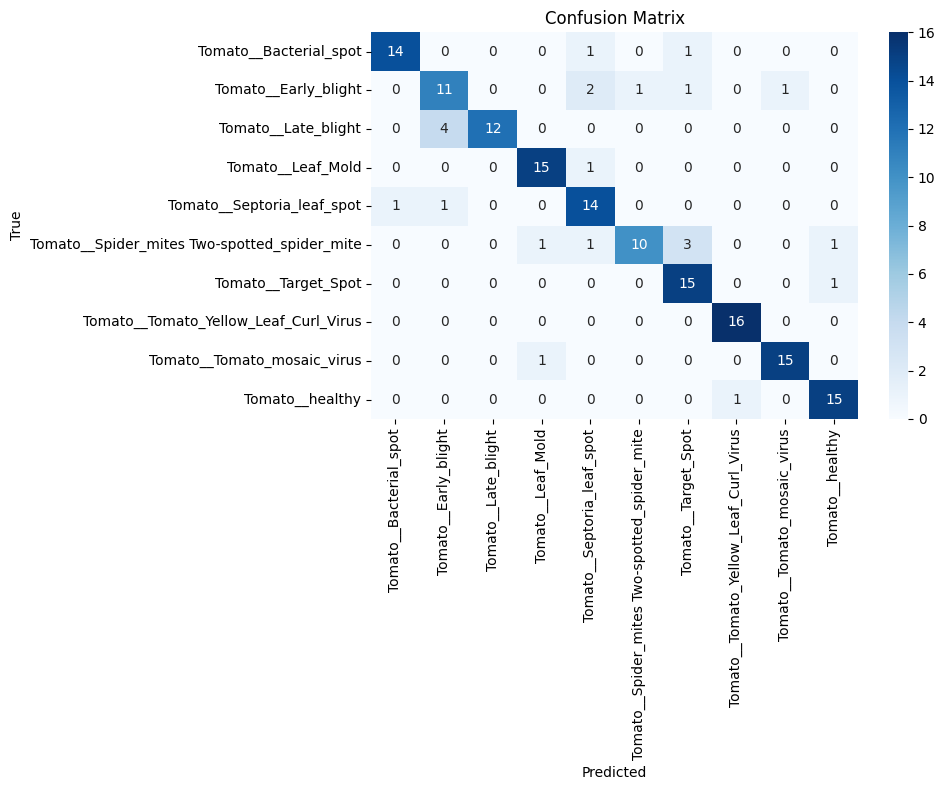

In [1]:
# notebooks/2_eval_model.ipynb (content as Python script)

# Step 1: Imports
import os
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 2: Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Step 3: Paths
test_dir = '../data/test'
model_path = '../models/tomato_resnet18.pth'

# Step 4: Transforms for test
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Step 5: Load test dataset
test_ds = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)
class_names = test_ds.classes
print("Test Classes:", class_names)

# Step 6: Load model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Step 7: Evaluation loop
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Step 8: Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Step 9: Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
os.makedirs("../outputs", exist_ok=True)
plt.savefig("../outputs/confusion_matrix.png")
plt.show()
